In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.fft import fft, ifft
import pandas as pd
import glob
import sipm.util.functions as func
from datetime import datetime
plt.style.use('darkside')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
!pwd

/home/as111/sipm-analysis


In [3]:
# data folder
path = ["/scratch/gpfs/as111/results/2023-04-28","/scratch/gpfs/as111/results/2023-04-27"]
data_spe = {}
positions = ['top', 'bottom']
channels = [0, 1, 2, 3]
voltages = [63, 65, 67, 69, 71]
for i,pos in enumerate(positions):
    data_spe[pos] = {}
    for ch in channels:
        data_spe[pos][ch] = {}
        for volt in voltages:
            data_spe[pos][ch][volt] = {'n_spe_wfs':0, 'avg_spe_wf':np.zeros(0), 'time':np.zeros(0)}
            files = glob.glob(f"{path[i]}/*volt_{volt}_pos_{pos}*laser_waveform.h5")
            for f in files:
                df = pd.read_hdf(f, key=f'{volt}/{ch}')
                data_spe[pos][ch][volt]['n_spe_wfs'] += np.array(df['n_spe_wfs'])[0]
                if data_spe[pos][ch][volt]['time'].shape[0]==0:
                    data_spe[pos][ch][volt]['time'] = np.array(df['time'])
                if np.array(df['n_spe_wfs'])[0]>0:
                    if data_spe[pos][ch][volt]['avg_spe_wf'].shape[0]==0:
                        data_spe[pos][ch][volt]['avg_spe_wf'] = np.array(df['avg_spe_wf'])*np.array(df['n_spe_wfs'])[0]
                    else:
                        data_spe[pos][ch][volt]['avg_spe_wf'] += np.array(df['avg_spe_wf'])*np.array(df['n_spe_wfs'])[0]
                    # if volt==65 and pos=='bottom':
                    #     print(np.array(df['n_spe_wfs'])[0],np.array(df['avg_spe_wf']))
            df = None
            data_spe[pos][ch][volt]['avg_spe_wf'] /= data_spe[pos][ch][volt]['n_spe_wfs']
print('keys: ', list(data_spe['top'][0][63].keys()))

keys:  ['n_spe_wfs', 'avg_spe_wf', 'time']


top ch0 63V 22172 waveforms selected
top ch0 65V 19308 waveforms selected
top ch0 67V 16706 waveforms selected
top ch0 69V 14233 waveforms selected
top ch0 71V 12609 waveforms selected
top ch1 63V 21911 waveforms selected
top ch1 65V 18354 waveforms selected
top ch1 67V 16157 waveforms selected
top ch1 69V 13996 waveforms selected
top ch1 71V 12173 waveforms selected
top ch2 63V 22628 waveforms selected
top ch2 65V 19412 waveforms selected
top ch2 67V 17157 waveforms selected
top ch2 69V 14947 waveforms selected
top ch2 71V 13038 waveforms selected
top ch3 63V 24930 waveforms selected
top ch3 65V 21521 waveforms selected
top ch3 67V 19040 waveforms selected
top ch3 69V 16494 waveforms selected
top ch3 71V 14564 waveforms selected
bottom ch0 63V 12081 waveforms selected
bottom ch0 65V 6881 waveforms selected
bottom ch0 67V 8486 waveforms selected
bottom ch0 69V 7168 waveforms selected
bottom ch0 71V 5640 waveforms selected
bottom ch1 63V 11688 waveforms selected
bottom ch1 65V 6861 wave

Text(0.07, 0.5, 'Amplitude (ADC Unit)')

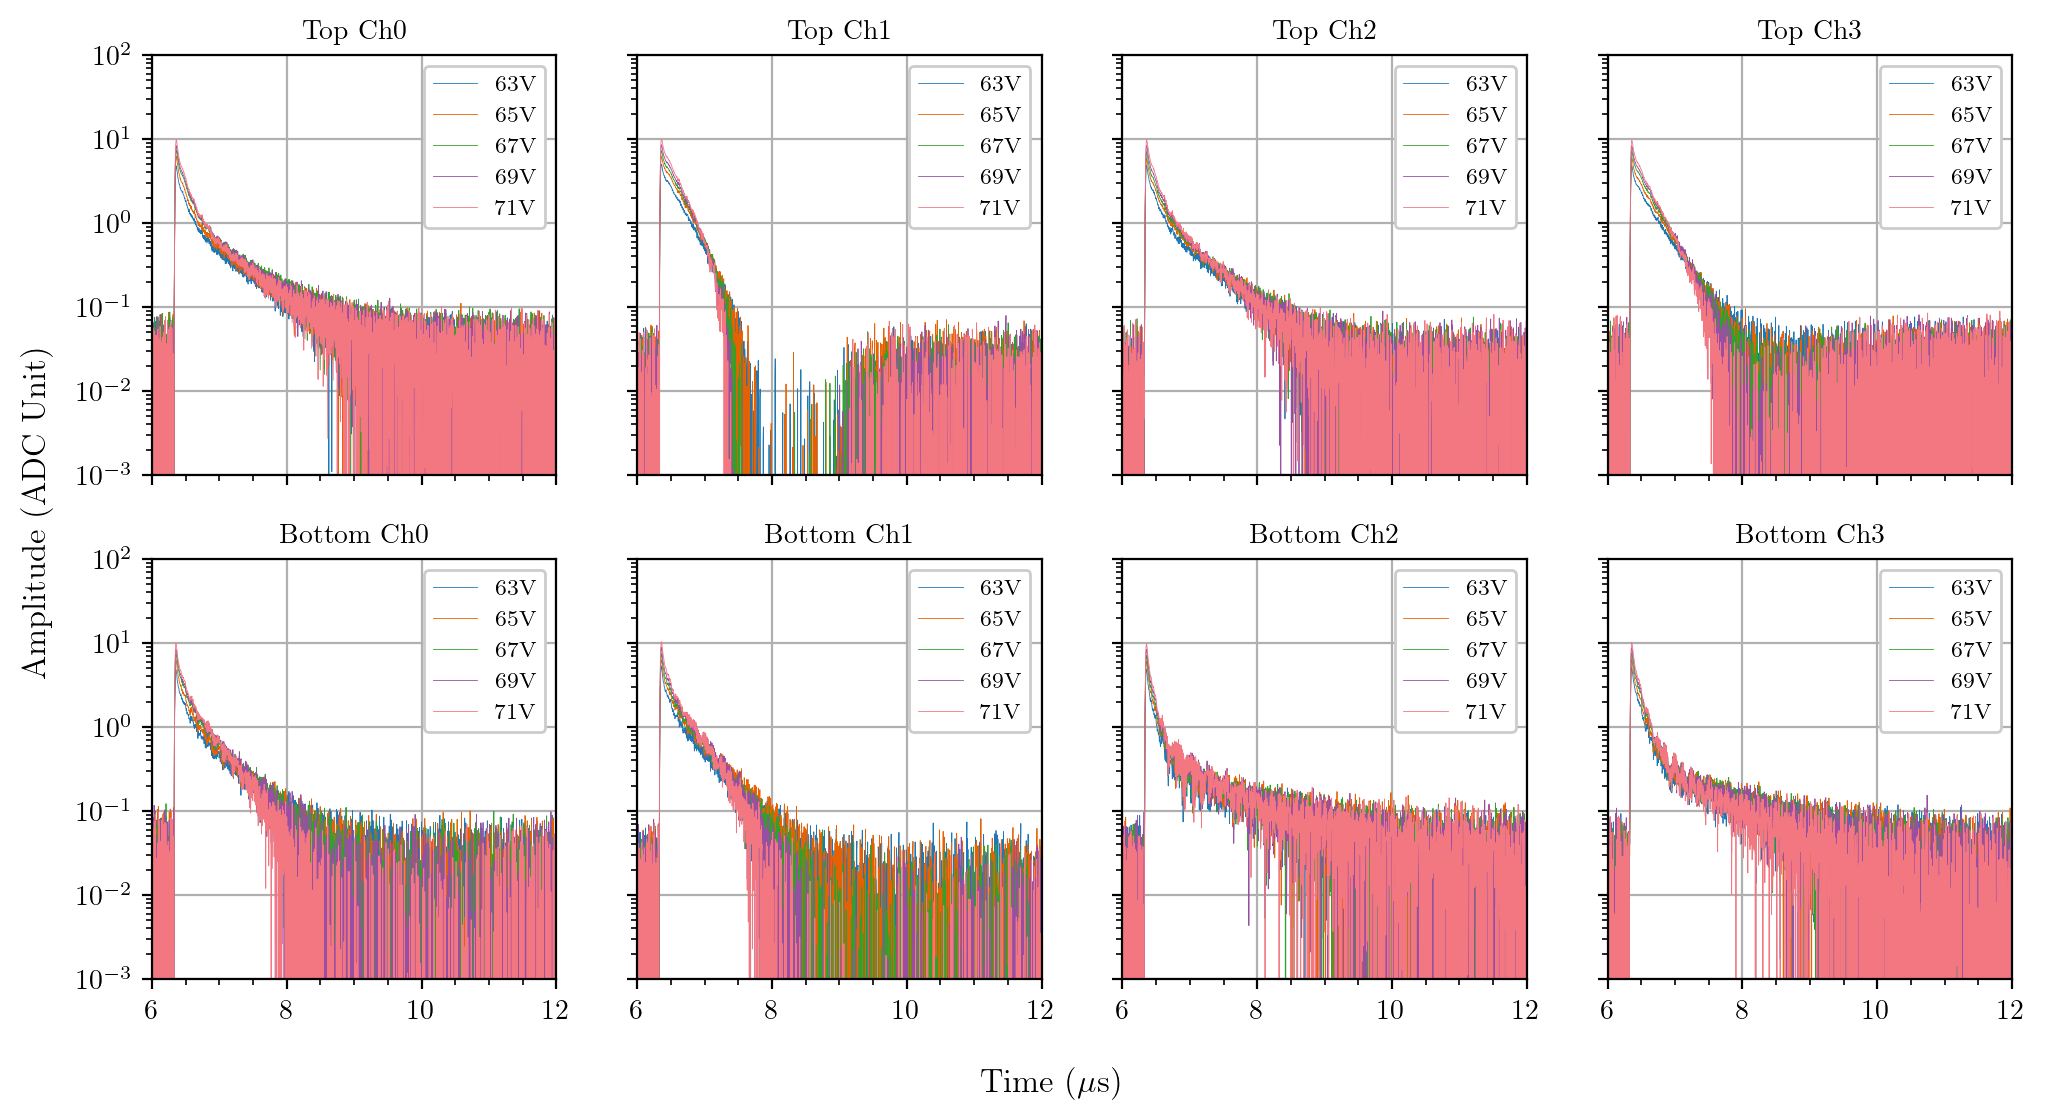

In [4]:
# Make plots for all datasets
# SPE average waveform
fig, axs = plt.subplots(2, 4, sharex=True, sharey=True)
fig.set_size_inches(12, 6)
for i, pos in enumerate(positions):
    for j, ch in enumerate(channels):
        for k, volt in enumerate(voltages):
            print(f'{pos} ch{ch} {volt}V {data_spe[pos][ch][volt]["n_spe_wfs"]:.0f} waveforms selected')
            axs[i, j].plot(
                data_spe[pos][ch][volt]['time'],
                data_spe[pos][ch][volt]['avg_spe_wf'],
                label=f'{volt}V', color=f'C{k}', linewidth=0.3)
        axs[i, j].legend(loc='upper right')
        axs[i, j].set_xlim(6, 12)
        axs[i, j].set_ylim(1e-3, 1e2)
        axs[i, j].set_yscale('log')
        axs[i, j].minorticks_on()
        axs[i, j].grid()
        axs[i, j].set_title(f'{pos[0].upper()}{pos[1:]} Ch{ch}')
fig.supxlabel(r'Time ($\mu$s)', y=0.01)
fig.supylabel(r'Amplitude (ADC Unit)', x=0.07)

In [5]:
data_spe['bottom'][1][65]['avg_spe_wf']

array([-0.09973783,  0.02706585,  0.02837761, ...,  0.02167305,
        0.01992403,  0.05228083])

## FFT

Text(0.07, 0.5, 'FFT Abs. Amplitude (ADC Unit)')

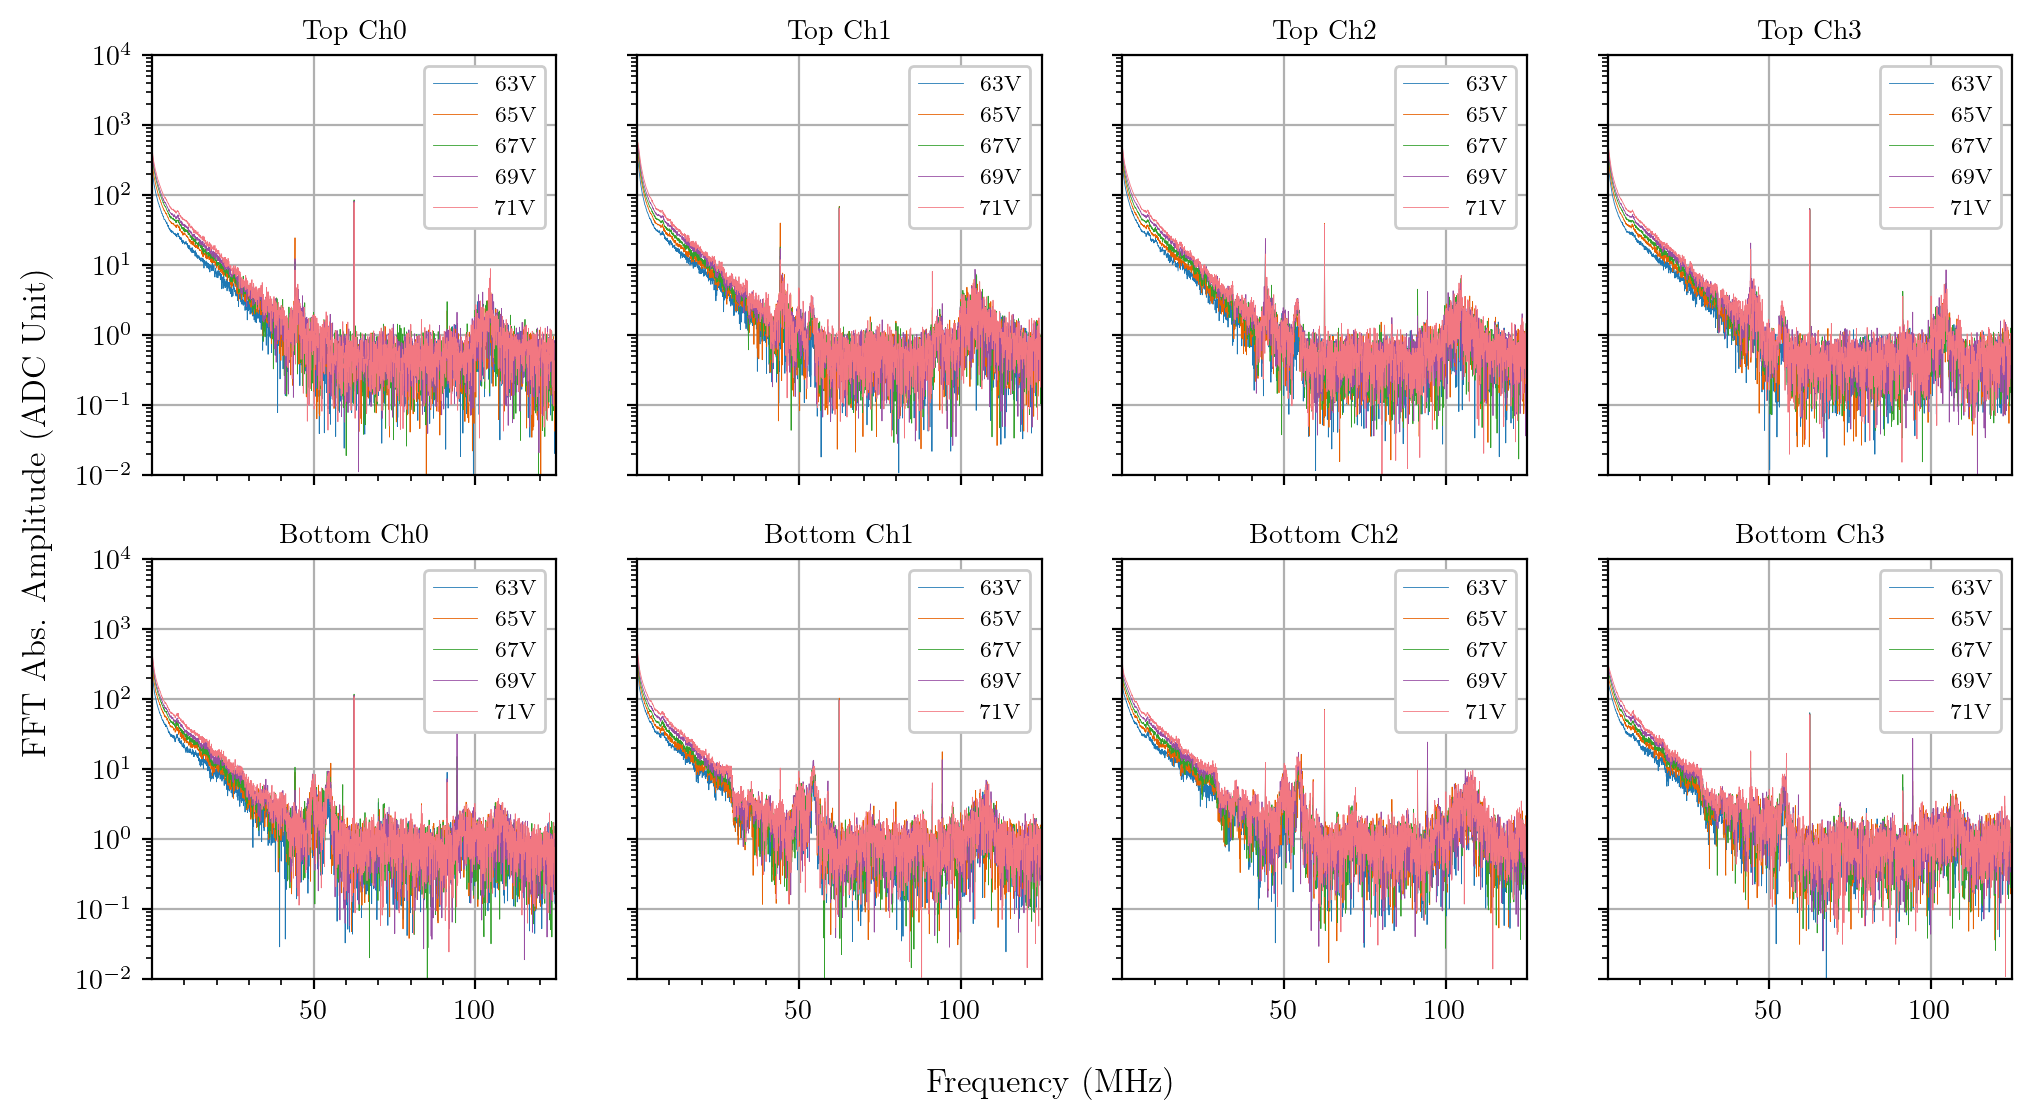

In [6]:
# Make plots for all datasets
# SPE average waveform
fig, axs = plt.subplots(2, 4, sharex=True, sharey=True)
fig.set_size_inches(12, 6)
for i, pos in enumerate(positions):
    for j, ch in enumerate(channels):
        for k, volt in enumerate(voltages):
            data_spe[pos][ch][volt]['fft_spe_wf'] = fft(data_spe[pos][ch][volt]['avg_spe_wf'])
            dt = data_spe[pos][ch][volt]['time'][1]-data_spe[pos][ch][volt]['time'][0]
            t_total = dt+data_spe[pos][ch][volt]['time'][-1]
            n_over_2 = int(data_spe[pos][ch][volt]['time'].shape[0]/2)
            data_spe[pos][ch][volt]['frequency'] = data_spe[pos][ch][volt]['time']/dt/t_total
            axs[i, j].plot(
                data_spe[pos][ch][volt]['frequency'][:n_over_2],
                abs(data_spe[pos][ch][volt]['fft_spe_wf'][:n_over_2]),
                label=f'{volt}V', color=f'C{k}', linewidth=0.3)
        axs[i, j].legend(loc='upper right')
        axs[i, j].set_xlim(data_spe[pos][ch][volt]['frequency'][1], data_spe[pos][ch][volt]['frequency'][n_over_2])
        # axs[i, j].set_xlim(0,5)
        axs[i, j].set_ylim(1e-2, 1e4)
        # axs[i, j].set_xscale('log')
        axs[i, j].set_yscale('log')
        axs[i, j].minorticks_on()
        axs[i, j].grid()
        axs[i, j].set_title(f'{pos[0].upper()}{pos[1:]} Ch{ch}')
fig.supxlabel(r'Frequency (MHz)', y=0.01)
fig.supylabel(r'FFT Abs. Amplitude (ADC Unit)', x=0.07)

# Fit: exponential pulses with time jitter
Scintillation pulse (one component):
$$h(t,t') = A e^{-\frac{t-t'}{\tau}} \Theta(t-t')$$
Time jitter:
$$g(t') = \frac{1}{\sigma \sqrt{2\pi}} e^{-\frac{(t'-t_0)^2}{2\sigma^2}}$$
Average waveform:
$$
f(t,t') = \int g(t') h(t,t') \, dt'
= \frac{A}{\sigma\sqrt{2\pi}} \int_{-\infty}^{t} e^{-\frac{(t'-t_0)^2}{2\sigma^2}-\frac{t-t'}{\tau}} \, dt'$$

$$ = \frac{A}{\sigma\sqrt{2\pi}} \int_{-\infty}^{t} e^{-\frac{1}{2\sigma^2}[t^{'2} - 2t'(t_0 + \sigma^2/\tau) + t_0^2 + 2\sigma^2 t_0/\tau + \sigma^4 /\tau^2 + 2\sigma^2 (t-t_0)/\tau - \sigma^4/\tau^2]} \, dt'
$$

$$
= \frac{Ae^{\frac{\sigma^2}{2\tau^2}}}{\sigma\sqrt{2\pi}} e^{-\frac{t-t_0}{\tau}} \int_{-\infty}^{t} e^{-\frac{1}{2\sigma^2}[t'-(t_0 + \sigma^2/\tau)]^2} \, dt'
$$

$$
= \frac{Ae^{\frac{\sigma^2}{2\tau^2}}}{\sqrt{\pi}} e^{-\frac{t-t_0}{\tau}} \int_{-\infty}^{t/\sigma\sqrt{2}} e^{-[x'-\frac{t_0 + \sigma^2/\tau}{\sigma\sqrt{2}}]^2} \, dx'
$$

$$
= \frac{Ae^{\frac{\sigma^2}{2\tau^2}}}{2} e^{-\frac{t-t_0}{\tau}} \left[1 + erf\left(\frac{t-t_0-\sigma^2/\tau}{\sigma\sqrt{2}}\right)\right]
$$
We include two scintillation pulse components with distinct $\tau$.

In [7]:
def template(t, a_1, tau_1, a_2, tau_2, sigma, t0):
        return func.pulse_jitter(t, a_1, tau_1, sigma, t0) + func.pulse_jitter(t, a_2, tau_2, sigma, t0)

In [8]:
# Fit SPE average waveform
for i, pos in enumerate(positions):
    for j, ch in enumerate(channels):
        for k, volt in enumerate(voltages):
            pretrg = 5 #us
            err = np.std(data_spe[pos][ch][volt]['avg_spe_wf'][data_spe[pos][ch][volt]['time']<pretrg])
            fit_range = [6.2,10] #us
            range_arr = (data_spe[pos][ch][volt]['time']<fit_range[1])&(data_spe[pos][ch][volt]['time']>fit_range[0])
            # print(pos,ch,volt)
            # print(data_spe[pos][ch][volt]['time'][range_arr])
            # print(data_spe[pos][ch][volt]['avg_spe_wf'][range_arr])
            popt,pcov = curve_fit(
                template,
                data_spe[pos][ch][volt]['time'][range_arr], 
                data_spe[pos][ch][volt]['avg_spe_wf'][range_arr], 
                p0=[7, 0.05, 6, 0.7, 0.008, 6.34], sigma=err*np.ones(np.sum(range_arr)), maxfev=100000)
            data_spe[pos][ch][volt]['pars'] = popt
            data_spe[pos][ch][volt]['cov'] = pcov

/home/as111/sipm-analysis/sipm/util/functions.py:24: RuntimeWarning: overflow encountered in exp
  return a*np.exp(sigma**2/2/tau**2)*np.exp(-(t-t0)/tau)*(1+erf((t-t0-sigma**2/tau)/sigma/np.sqrt(2)))/2
/home/as111/sipm-analysis/sipm/util/functions.py:24: RuntimeWarning: overflow encountered in multiply
  return a*np.exp(sigma**2/2/tau**2)*np.exp(-(t-t0)/tau)*(1+erf((t-t0-sigma**2/tau)/sigma/np.sqrt(2)))/2
/home/as111/miniconda3/envs/sipm/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:504: RuntimeWarning: overflow encountered in multiply
  return transform * (func(xdata, *params) - ydata)


Text(0.07, 0.5, 'Amplitude (ADC Unit)')

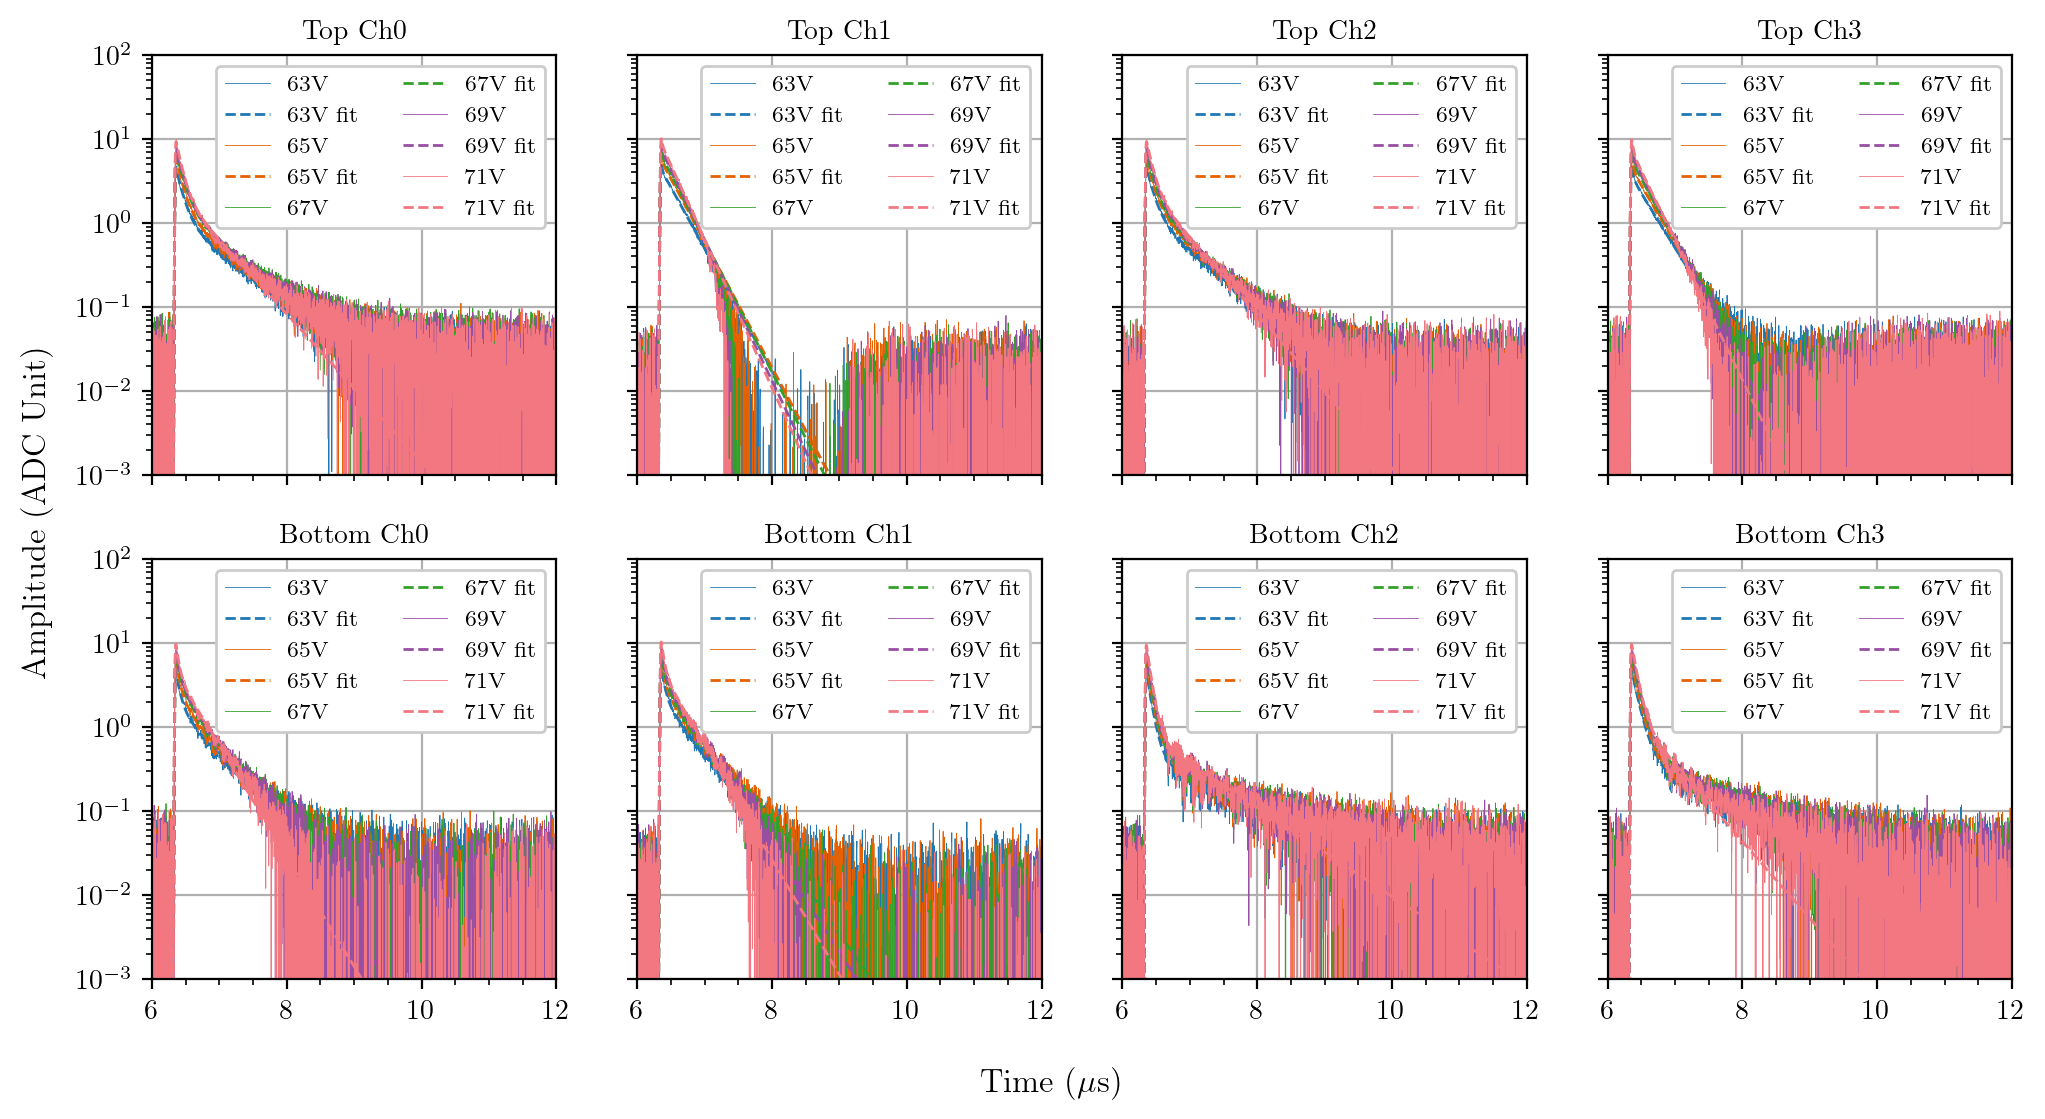

In [9]:
# Make plots for all datasets
# Fitted SPE average waveform
fig, axs = plt.subplots(2, 4, sharex=True, sharey=True)
fig.set_size_inches(12, 6)
for i, pos in enumerate(positions):
    for j, ch in enumerate(channels):
        for k, volt in enumerate(voltages):
            axs[i, j].plot(
                data_spe[pos][ch][volt]['time'],
                data_spe[pos][ch][volt]['avg_spe_wf'],
                label=f'{volt}V', color=f'C{k}', linewidth=0.3)
            axs[i, j].plot(
                data_spe[pos][ch][volt]['time'],
                template(data_spe[pos][ch][volt]['time'], *data_spe[pos][ch][volt]['pars']),
                label=f'{volt}V fit', color=f'C{k}', linestyle='--', linewidth=1)
        axs[i, j].legend(loc='upper right',ncol=2)
        axs[i, j].set_xlim(6, 12)
        axs[i, j].set_ylim(1e-3, 1e2)
        axs[i, j].set_yscale('log')
        axs[i, j].minorticks_on()
        axs[i, j].grid()
        axs[i, j].set_title(f'{pos[0].upper()}{pos[1:]} Ch{ch}')
fig.supxlabel(r'Time ($\mu$s)', y=0.01)
fig.supylabel(r'Amplitude (ADC Unit)', x=0.07)

In [10]:
# Fit result container
# Initialize
spe_fit = {}
for pos in positions:
    spe_fit[pos] = {}
    for ch in channels:
        spe_fit[pos][ch] = {}

In [11]:
for i, pos in enumerate(positions):
    for j, ch in enumerate(channels):
            spe_fit[pos][ch]['volts'] = np.array(voltages)
            spe_fit[pos][ch]['a1'] = np.array([data_spe[pos][ch][volt]['pars'][0] for volt in voltages])
            spe_fit[pos][ch]['tau1'] = np.array([data_spe[pos][ch][volt]['pars'][1] for volt in voltages])
            spe_fit[pos][ch]['a2'] = np.array([data_spe[pos][ch][volt]['pars'][2] for volt in voltages])
            spe_fit[pos][ch]['tau2'] = np.array([data_spe[pos][ch][volt]['pars'][3] for volt in voltages])
            spe_fit[pos][ch]['a1err'] = np.array([func.error_distance(df=6, sigma=1)*np.sqrt(data_spe[pos][ch][volt]['cov'][0, 0]) for volt in voltages])
            spe_fit[pos][ch]['tau1err'] = np.array([func.error_distance(df=6, sigma=1)*np.sqrt(data_spe[pos][ch][volt]['cov'][1, 1]) for volt in voltages])
            spe_fit[pos][ch]['a2err'] = np.array([func.error_distance(df=6, sigma=1)*np.sqrt(data_spe[pos][ch][volt]['cov'][2, 2]) for volt in voltages])
            spe_fit[pos][ch]['tau2err'] = np.array([func.error_distance(df=6, sigma=1)*np.sqrt(data_spe[pos][ch][volt]['cov'][3, 3]) for volt in voltages])

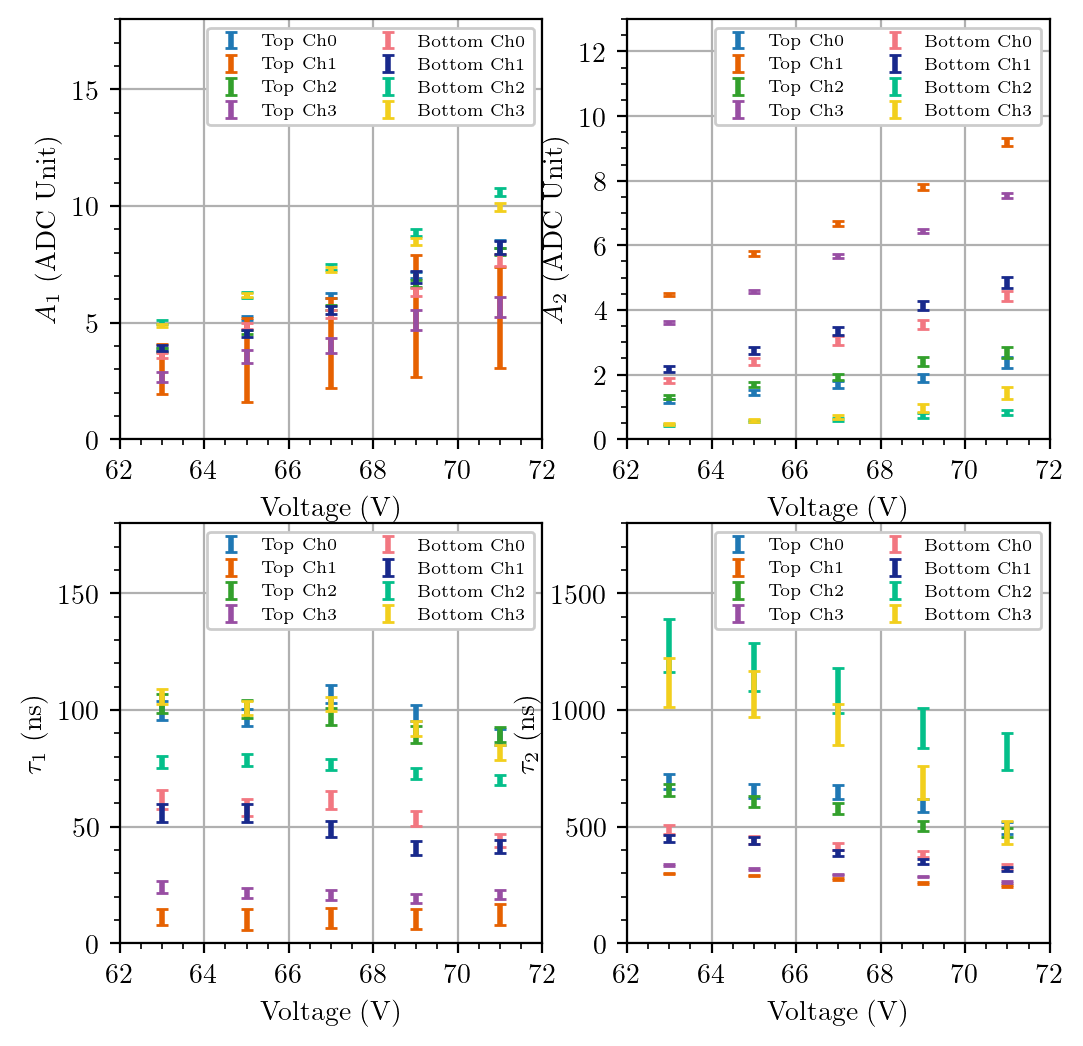

In [12]:
# Make plots for all parameters
# SPE average waveform
fig, axs = plt.subplots(2, 2, sharex=False, sharey=False)
fig.set_size_inches(6, 6)
for i, pos in enumerate(positions):
    for j, ch in enumerate(channels):
        axs[0, 0].errorbar(
            spe_fit[pos][ch]['volts'],
            spe_fit[pos][ch]['a1'],
            yerr=spe_fit[pos][ch]['a1err'],
            label=f'{pos[0].upper()}{pos[1:]} Ch{ch}', color=f'C{i*4+j}', linestyle='')
        axs[0, 0].set_ylabel(r'$A_1$ (ADC Unit)')
        axs[0, 0].set_ylim(0,18)
        axs[0, 1].errorbar(
            spe_fit[pos][ch]['volts'],
            spe_fit[pos][ch]['a2'],
            yerr=spe_fit[pos][ch]['a2err'],
            label=f'{pos[0].upper()}{pos[1:]} Ch{ch}', color=f'C{i*4+j}', linestyle='')
        axs[0, 1].set_ylabel(r'$A_2$ (ADC Unit)')
        axs[0, 1].set_ylim(0,13)
        axs[1, 0].errorbar(
            spe_fit[pos][ch]['volts'],
            spe_fit[pos][ch]['tau1']*1e3,
            yerr=spe_fit[pos][ch]['tau1err']*1e3,
            label=f'{pos[0].upper()}{pos[1:]} Ch{ch}', color=f'C{i*4+j}', linestyle='')
        axs[1, 0].set_ylabel(r'$\tau_1$ (ns)')
        axs[1, 0].set_ylim(0,180)
        axs[1, 1].errorbar(
            spe_fit[pos][ch]['volts'],
            spe_fit[pos][ch]['tau2']*1e3,
            yerr=spe_fit[pos][ch]['tau2err']*1e3,
            label=f'{pos[0].upper()}{pos[1:]} Ch{ch}', color=f'C{i*4+j}', linestyle='')
        axs[1, 1].set_ylabel(r'$\tau_2$ (ns)')
        axs[1, 1].set_ylim(0,1800)

for i in range(2):
    for j in range(2):
        axs[i, j].set_xlabel('Voltage (V)')
        axs[i, j].legend(loc='upper right',ncol=2,fontsize=6)
        axs[i, j].minorticks_on()
        axs[i, j].grid()

# 11/20 Triplet lifetime
Here the average waveforms are deconvolved channel-by-channel using their respective SPE pulse shapes.
The deconvolved waveform is given by
$$f_{deconv}(t) = \mathcal{F}^{-1}\left(\frac{\mathcal{F}(f_{original}(t))}{\mathcal{F}(f_{SiPM}(t))}\right)$$
Note that the SiPM pulse shape has to be shifted such that the trigger for it is at $t=0$.<br>

The average waveforms are selected from the events with $0.1<F_{\rm prompt}<0.5$ and $20<N_{\rm PE}<200$ ($100<N_{\rm PE}<1000$) for the top (bottom), corresponding to an energy range of $100$ keV $\lesssim E \lesssim 1000$ keV

In [13]:
# data folder
path_scint = "/scratch/gpfs/as111/results/2023-05-04/"
data_scint = {}
positions = ['top', 'bottom']
channels = [0, 1, 2, 3]
voltages = [67]
for pos in positions:
    data_scint[pos] = {}
    for ch in channels:
        data_scint[pos][ch] = {}
        for volt in voltages:
            data_scint[pos][ch][volt] = {'n_scint_wfs':0, 'avg_scint_wf':np.zeros(0), 'time':np.zeros(0)}
            files = glob.glob(f"{path_scint}/*volt_{volt}_pos_{pos}*scintillation_waveform.h5")
            for f in files:
                df = pd.read_hdf(f, key=f'{volt}/{ch}')
                data_scint[pos][ch][volt]['n_scint_wfs'] += np.array(df['n_scint_wfs'])[0]
                if data_scint[pos][ch][volt]['time'].shape[0]==0:
                    data_scint[pos][ch][volt]['time'] = np.array(df['time'])
                if data_scint[pos][ch][volt]['avg_scint_wf'].shape[0]==0:
                    data_scint[pos][ch][volt]['avg_scint_wf'] = np.array(df['avg_scint_wf'])*np.array(df['n_scint_wfs'])[0]
                else:
                    data_scint[pos][ch][volt]['avg_scint_wf'] += np.array(df['avg_scint_wf'])*np.array(df['n_scint_wfs'])[0]
            df = None
            data_scint[pos][ch][volt]['avg_scint_wf'] /= data_scint[pos][ch][volt]['n_scint_wfs']
print('keys: ', list(data_scint['top'][0][67].keys()))

keys:  ['n_scint_wfs', 'avg_scint_wf', 'time']


top ch0 67V 1503378 waveforms selected
top ch1 67V 1503378 waveforms selected
top ch2 67V 1503378 waveforms selected
top ch3 67V 1503378 waveforms selected
bottom ch0 67V 788479 waveforms selected
bottom ch1 67V 788479 waveforms selected
bottom ch2 67V 788479 waveforms selected
bottom ch3 67V 788479 waveforms selected


Text(0.07, 0.5, 'Amplitude (ADC Unit)')

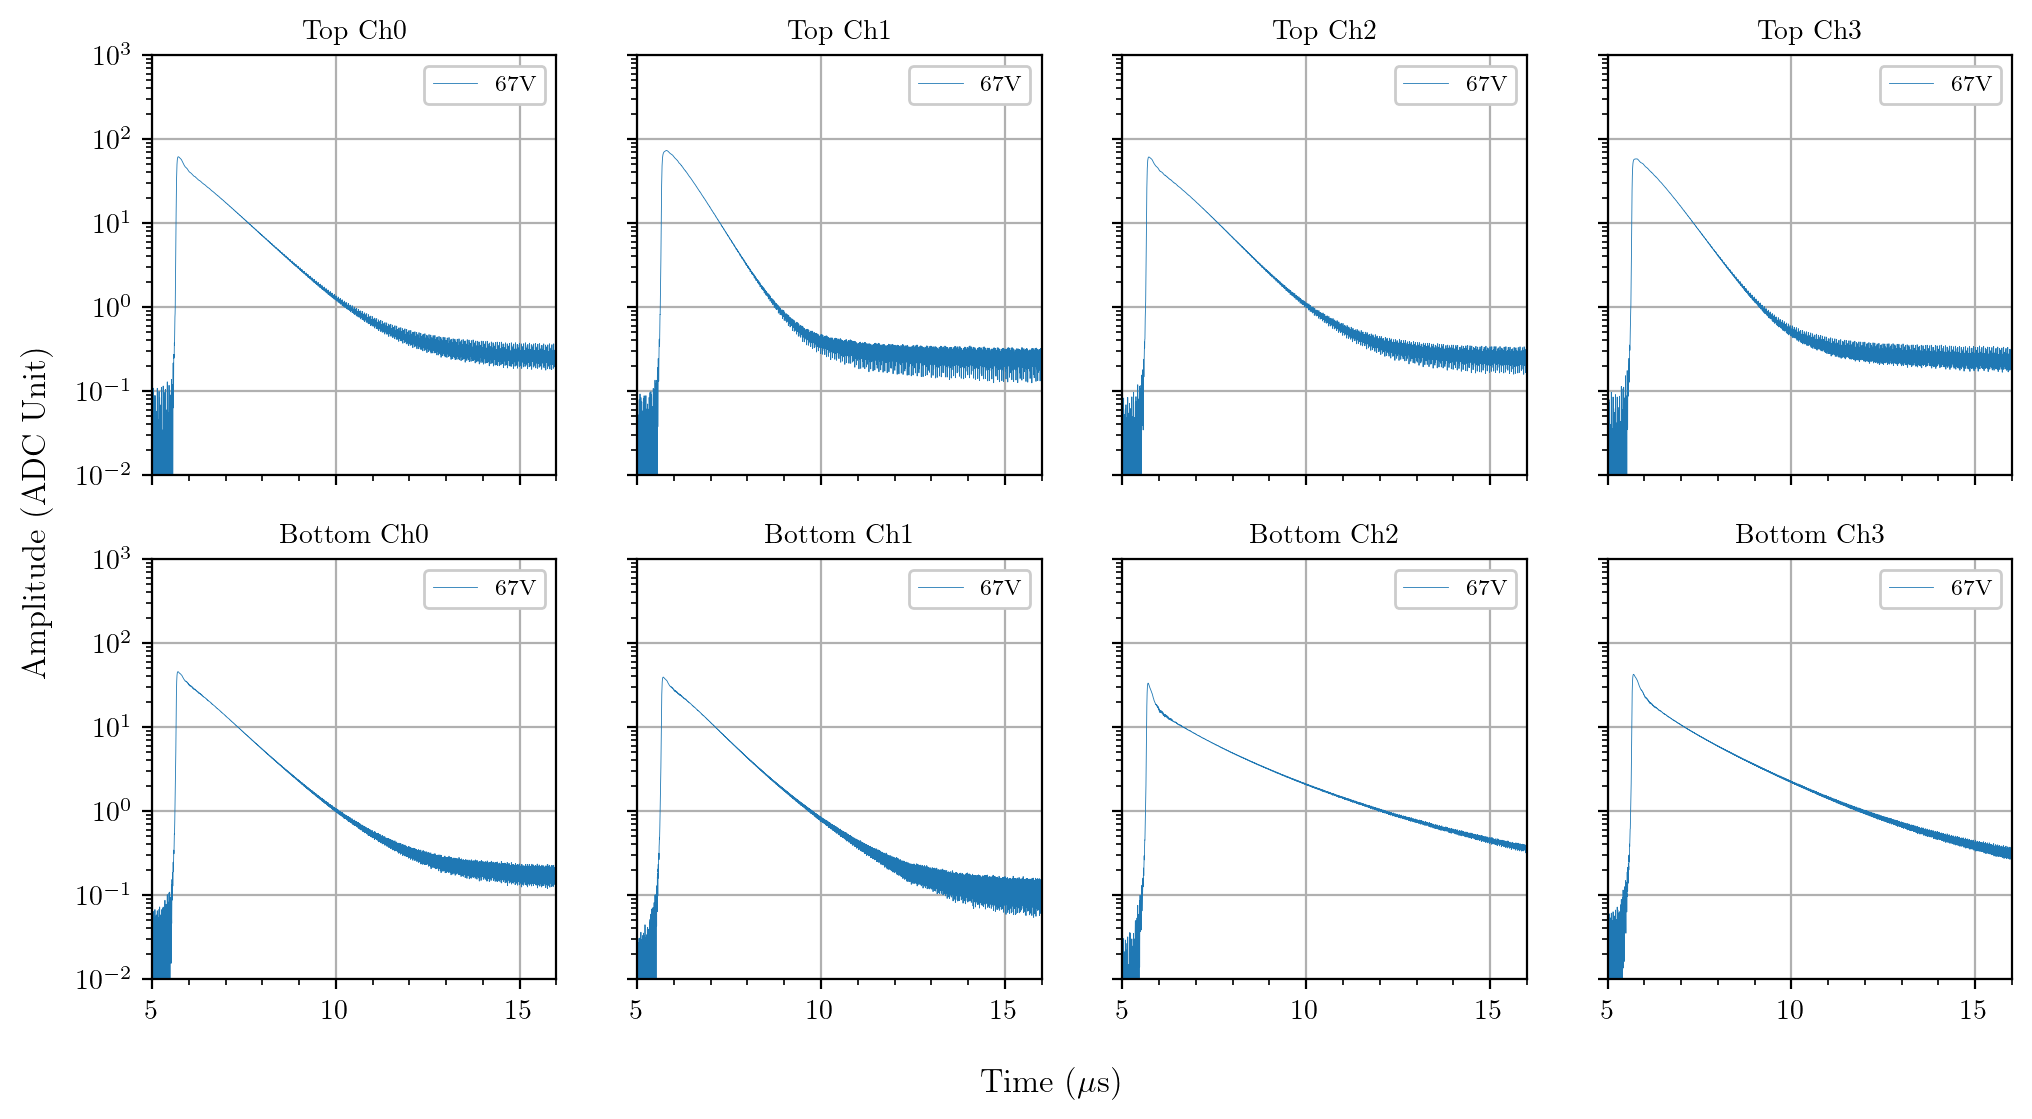

In [14]:
# Make plots for all datasets
# Average LAr scintillation waveform
fig, axs = plt.subplots(2, 4, sharex=True, sharey=True)
fig.set_size_inches(12, 6)
for i, pos in enumerate(positions):
    for j, ch in enumerate(channels):
        for k, volt in enumerate(voltages):
            print(f'{pos} ch{ch} {volt}V {data_scint[pos][ch][volt]["n_scint_wfs"]:.0f} waveforms selected')
            axs[i, j].plot(
                data_scint[pos][ch][volt]['time'],
                data_scint[pos][ch][volt]['avg_scint_wf'],
                label=f'{volt}V', color=f'C{k}', linewidth=0.3)
        axs[i, j].legend(loc='upper right')
        axs[i, j].set_xlim(5, 16)
        axs[i, j].set_ylim(1e-2, 1e3)
        axs[i, j].set_yscale('log')
        axs[i, j].minorticks_on()
        axs[i, j].grid()
        axs[i, j].set_title(f'{pos[0].upper()}{pos[1:]} Ch{ch}')
fig.supxlabel(r'Time ($\mu$s)', y=0.01)
fig.supylabel(r'Amplitude (ADC Unit)', x=0.07)

## Deconvolution

In [15]:
# Deconvolution channel by channel
for i, pos in enumerate(positions):
    for j, ch in enumerate(channels):
        for k, volt in enumerate(voltages):
            if data_scint[pos][ch][volt]['n_scint_wfs']>0 and data_spe[pos][ch][volt]['n_spe_wfs']>0:
                dt = data_spe[pos][ch][volt]['time'][1]-data_spe[pos][ch][volt]['time'][0]
                shift = np.array([np.exp(complex(0,-2*np.pi*freq*dt*int(data_spe[pos][ch][volt]['pars'][5]/dt))) for freq in data_spe[pos][ch][volt]['frequency']])
                data_scint[pos][ch][volt]['deconv'] = ifft(fft(data_scint[pos][ch][volt]['avg_scint_wf'])/data_spe[pos][ch][volt]['fft_spe_wf']*shift).real

Text(0.07, 0.5, 'Amplitude (ADC Unit)')

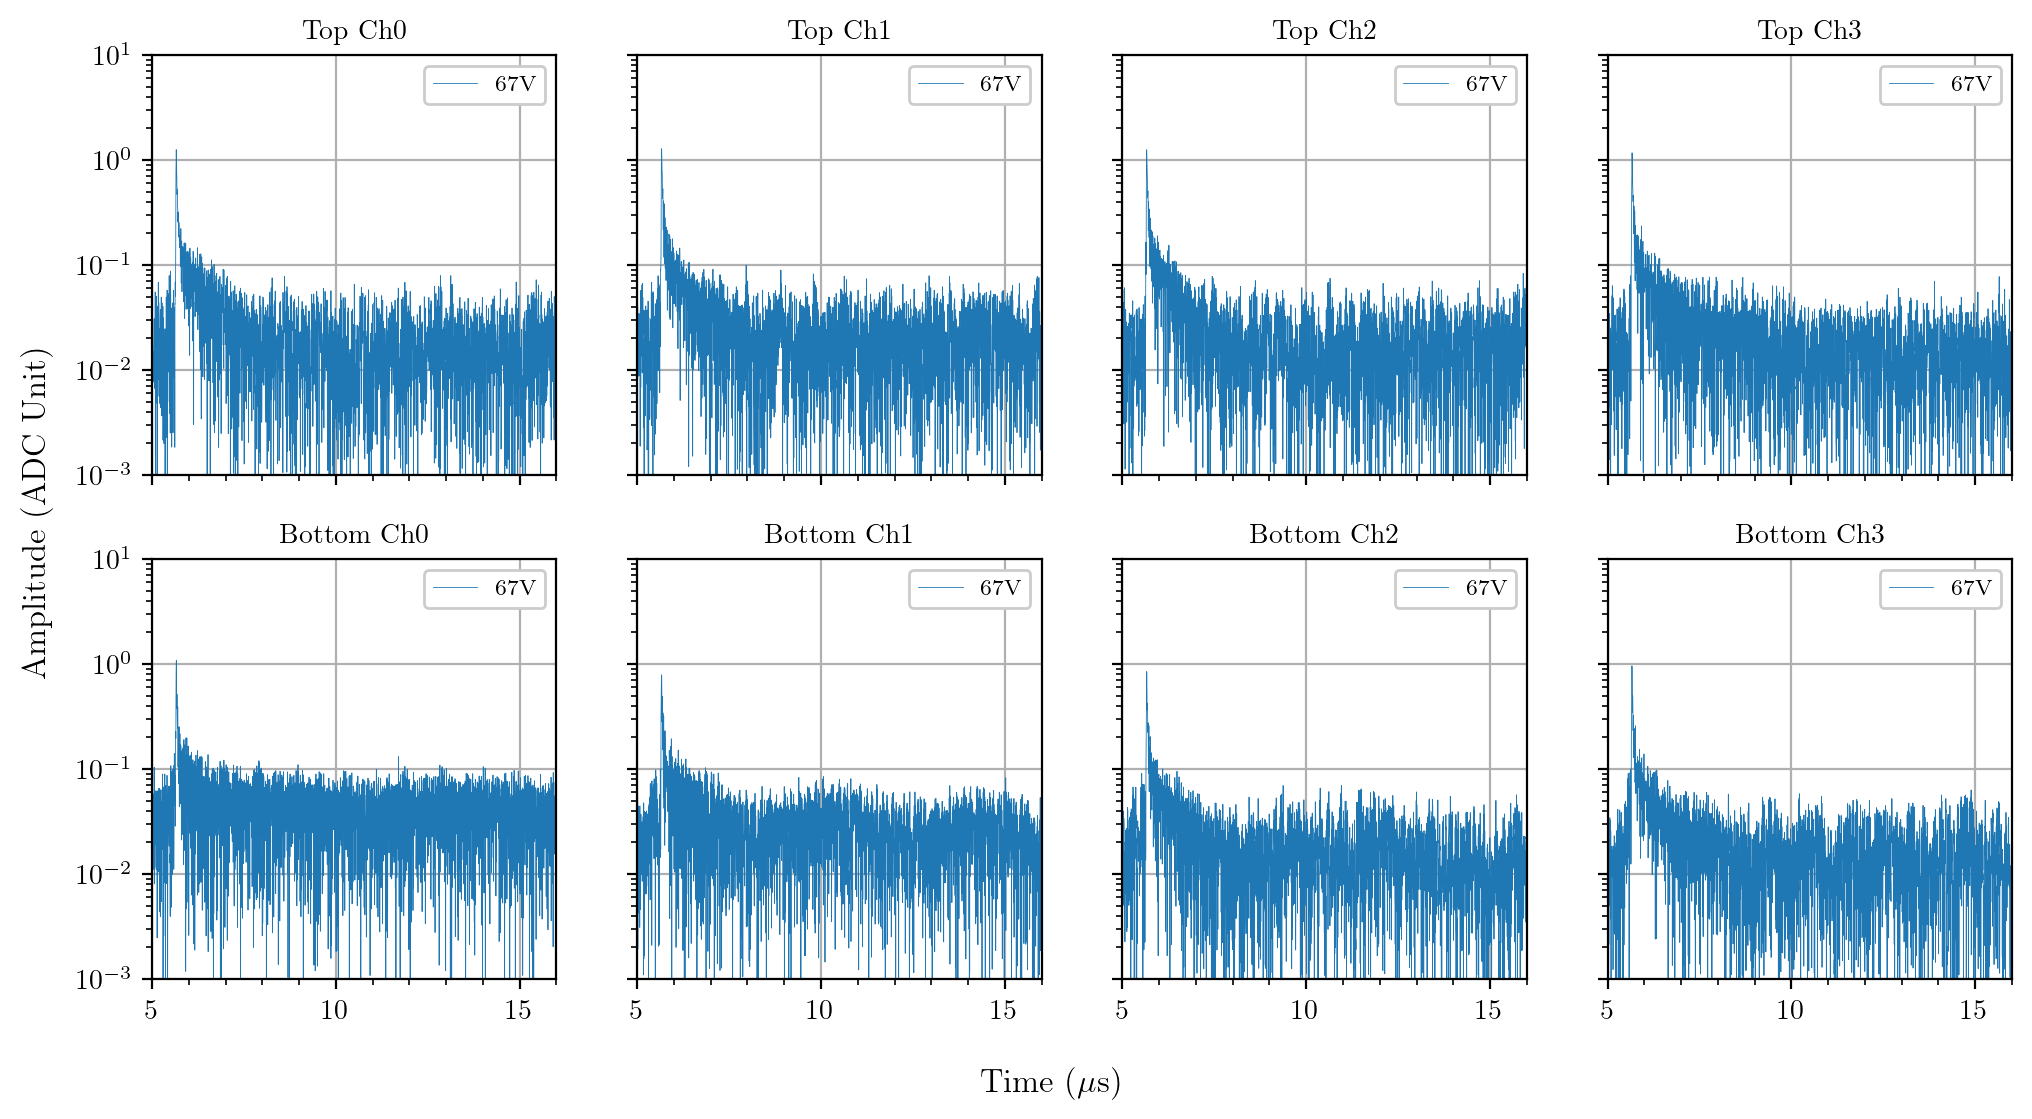

In [16]:
# Make plots for all datasets
# Deconvolved scintillation waveform
fig, axs = plt.subplots(2, 4, sharex=True, sharey=True)
fig.set_size_inches(12, 6)
for i, pos in enumerate(positions):
    for j, ch in enumerate(channels):
        for k, volt in enumerate(voltages):
            if data_scint[pos][ch][volt]['n_scint_wfs']>0 and data_spe[pos][ch][volt]['n_spe_wfs']>0:
                axs[i, j].plot(
                    data_scint[pos][ch][volt]['time'],
                    abs(data_scint[pos][ch][volt]['deconv']),
                    label=f'{volt}V', color=f'C{k}', linewidth=0.3)
        axs[i, j].legend(loc='upper right')
        axs[i, j].set_xlim(5, 16)
        axs[i, j].set_ylim(1e-3, 1e1)
        axs[i, j].set_yscale('log')
        axs[i, j].minorticks_on()
        axs[i, j].grid()
        axs[i, j].set_title(f'{pos[0].upper()}{pos[1:]} Ch{ch}')
fig.supxlabel(r'Time ($\mu$s)', y=0.01)
fig.supylabel(r'Amplitude (ADC Unit)', x=0.07)

## Summation

In [17]:
for pos in positions:
    data_scint[pos][-1] = {}
    for volt in voltages:
        data_scint[pos][-1][volt] = {'time': data_scint[pos][0][volt]['time'], 'sum_wf': np.zeros(data_scint[pos][0][volt]['time'].shape[0])}
        for ch in channels:
            if data_scint[pos][ch][volt]['n_scint_wfs']>0 and data_spe[pos][ch][volt]['n_spe_wfs']>0:
                data_scint[pos][-1][volt]['sum_wf'] += data_scint[pos][ch][volt]['deconv']

Text(0.02, 0.5, 'Amplitude (ADC Unit)')

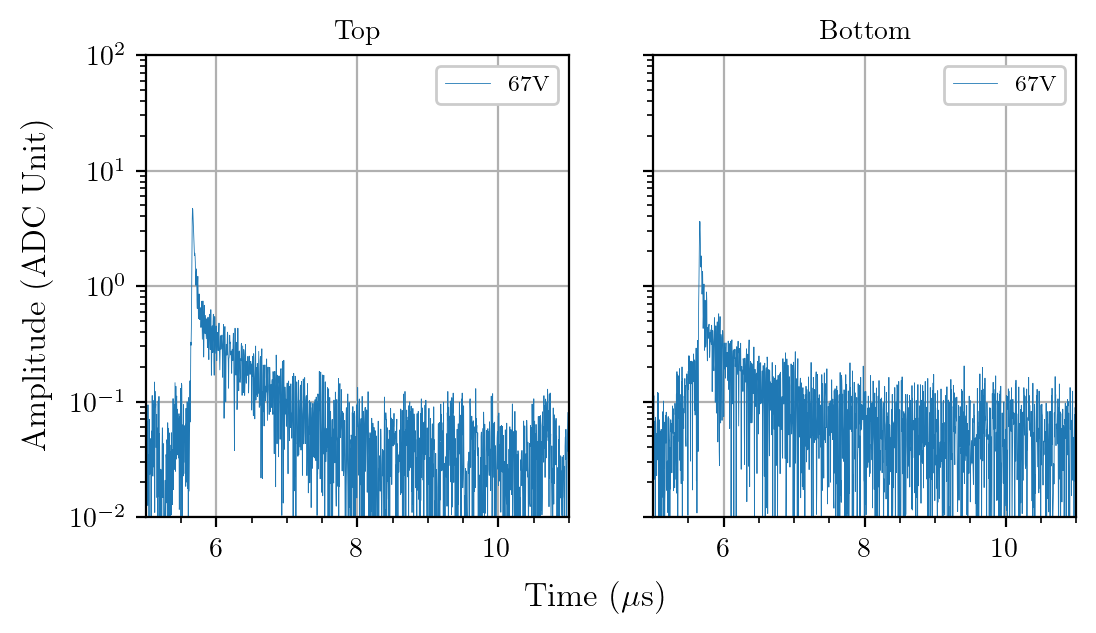

In [18]:
# Make plots for all datasets
# Summed scintillation waveform
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
fig.set_size_inches(6, 3)
for i, pos in enumerate(positions):
    for j, volt in enumerate(voltages):
        axs[i].plot(
                    data_scint[pos][-1][volt]['time'],
                    abs(data_scint[pos][-1][volt]['sum_wf']),
                    label=f'{volt}V', color=f'C{j}', linewidth=0.3)
        axs[i].legend(loc='upper right')
        axs[i].set_xlim(5, 11)
        axs[i].set_ylim(1e-2, 1e2)
        axs[i].set_yscale('log')
        axs[i].minorticks_on()
        axs[i].grid()
        axs[i].set_title(f'{pos[0].upper()}{pos[1:]}')
fig.supxlabel(r'Time ($\mu$s)', y=-0.05)
fig.supylabel(r'Amplitude (ADC Unit)', x=0.02)

## Fitting

In [19]:
# Fit SPE average waveform
for i, pos in enumerate(positions):
    for j, volt in enumerate(voltages):
        if data_scint[pos][-1][volt]['sum_wf'].shape[0]>0:
            pretrg = 5 #us
            err = np.std(data_scint[pos][-1][volt]['sum_wf'][data_scint[pos][-1][volt]['time']<pretrg])
            fit_range = [5.5,8] #us
            range_arr = (data_scint[pos][-1][volt]['time']<fit_range[1])&(data_scint[pos][-1][volt]['time']>fit_range[0])
            popt,pcov = curve_fit(
                template,
                data_scint[pos][-1][volt]['time'][range_arr], 
                data_scint[pos][-1][volt]['sum_wf'][range_arr], 
                p0=[5, 0.02, 0.5, 0.7, 0.005, 5.65], sigma=err*np.ones(np.sum(range_arr)), maxfev=100000)
            data_scint[pos][-1][volt]['pars'] = popt
            data_scint[pos][-1][volt]['cov'] = pcov
            print(f'{pos} {volt}V As={popt[0]} Ts={popt[1]}us At={popt[2]} Tt={popt[3]}us sigma={popt[4]}us t0={popt[5]}us')

top 67V As=5.89110709115192 Ts=0.02480773404379963us At=0.5992764139280238 Tt=0.7026780411918809us sigma=0.005139947864734588us t0=5.6532429753110724us
bottom 67V As=4.6424774199972845 Ts=0.020683017486741777us At=0.4199592936116282 Tt=0.7782725132583082us sigma=0.00561638488619871us t0=5.652261274370313us


Text(-0.07, 0.5, 'Amplitude (ADC Unit)')

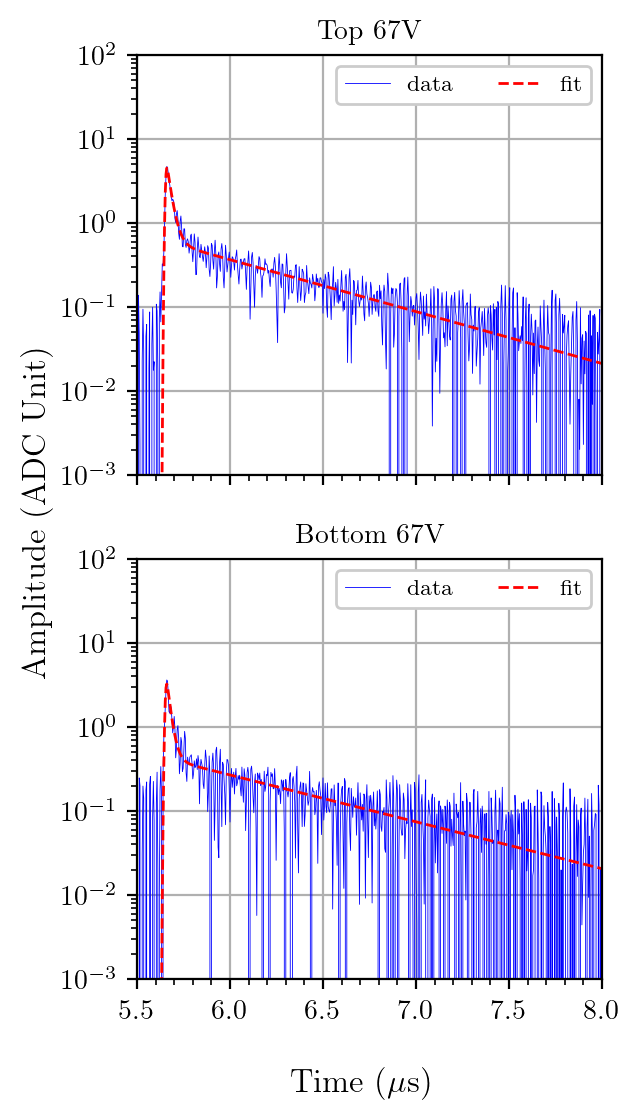

In [29]:
# Make plots for all datasets
# Fitted SPE average waveform
fig, axs = plt.subplots(2, 1, sharex=True, sharey=True)
fig.set_size_inches(3, 6)
volt = 67
for i, pos in enumerate(positions):
    if data_scint[pos][-1][volt]['sum_wf'].shape[0]>0:
        axs[i].plot(
            data_scint[pos][-1][volt]['time'],
            data_scint[pos][-1][volt]['sum_wf'],
            label=f'data', color='b', linewidth=0.3)
        axs[i].plot(
            data_scint[pos][-1][volt]['time'],
            template(data_scint[pos][-1][volt]['time'], *data_scint[pos][-1][volt]['pars']),
            label=f'fit', color='r', linestyle='--', linewidth=1)
        axs[i].legend(loc='upper right',ncol=2)
        axs[i].set_xlim(5.5, 8)
        axs[i].set_ylim(1e-3, 1e2)
        axs[i].set_yscale('log')
        axs[i].minorticks_on()
        axs[i].grid()
        axs[i].set_title(f'{pos[0].upper()}{pos[1:]} {volt}V')
fig.supxlabel(r'Time ($\mu$s)', y=0.01)
fig.supylabel(r'Amplitude (ADC Unit)', x=-0.07)

# Triplet lifetime evolution

Get folder paths and days since the getter was turned on

In [21]:
dt_getter = datetime(2023,5,2,16,0,0)
print('The getter was turned on at', dt_getter)

The getter was turned on at 2023-05-02 16:00:00


In [22]:
# Sort datasets
S_PER_DAY = 86400
directory = '/scratch/gpfs/as111/results/'
positions = ['top','bottom']
files_top = glob.glob(f'{directory}2023-05-02/*pos_top*scintillation_waveform.h5') + glob.glob(f'{directory}2023-05-03/*pos_top*scintillation_waveform.h5') + glob.glob(f'{directory}2023-05-04/*pos_top*scintillation_waveform.h5') + glob.glob(f'{directory}2023-05-05/*pos_top*scintillation_waveform.h5')+ glob.glob(f'{directory}2023-05-08/*pos_top*scintillation_waveform.h5')+ glob.glob(f'{directory}2023-05-09/*pos_top*scintillation_waveform.h5')+ glob.glob(f'{directory}2023-05-10/*pos_top*scintillation_waveform.h5') + glob.glob(f'{directory}2023-05-11/*pos_top*scintillation_waveform.h5')
files_bottom = glob.glob(f'{directory}2023-05-04/*pos_bottom*scintillation_waveform.h5') + glob.glob(f'{directory}2023-05-05/*pos_bottom*scintillation_waveform.h5') + glob.glob(f'{directory}2023-05-08/*pos_bottom*scintillation_waveform.h5')+ glob.glob(f'{directory}2023-05-09/*pos_bottom*scintillation_waveform.h5')+ glob.glob(f'{directory}2023-05-10/*pos_bottom*scintillation_waveform.h5')
files = {'top':files_top,'bottom':files_bottom}
datetime_files = {}
sorted_keys = {}
for pos in positions:
    datetime_files[pos] = {}
    for f in files[pos]:
        df = pd.read_hdf(f, key=f'67/-1')
        date_time = datetime(*np.array(df['start_datetime']).astype(int))
        days = (date_time-dt_getter).total_seconds()/S_PER_DAY
        datetime_files[pos][days] = f
    sorted_keys[pos] = list(datetime_files[pos].keys())
    sorted_keys[pos].sort()

In [23]:
data_triplet = {}
channels = [0,1,2,3]
for pos in positions:
    data_triplet[pos] = []
    for sorted_day in sorted_keys[pos]:
        file = datetime_files[pos][sorted_day]
        # Create a new dataset if >30mins apart from the last one
        if len(data_triplet[pos])==0 or sorted_day-data_triplet[pos][-1]['days']>1/48: 
            data_triplet[pos].append({
                'days': sorted_day, 
                'filename': [file], 
                'data':{}
            })
            for ch in channels:
                data_triplet[pos][-1]['data'][ch] = {'n_scint_wfs':0, 'avg_scint_wf':np.zeros(0), 'time':np.zeros(0)}
        else:
            data_triplet[pos][-1]['filename'].append(file)
    # Load data    
    for d in data_triplet[pos]:
        for ch in channels:
            for f in d['filename']:
                df = pd.read_hdf(f, key=f'67/{ch}')
                d['data'][ch]['n_scint_wfs'] += np.array(df['n_scint_wfs'])[0]
                if d['data'][ch]['time'].shape[0]==0:
                    d['data'][ch]['time'] = np.array(df['time'])
                if d['data'][ch]['avg_scint_wf'].shape[0]==0:
                    d['data'][ch]['avg_scint_wf'] = np.array(df['avg_scint_wf'])*np.array(df['n_scint_wfs'])[0]
                else:
                    d['data'][ch]['avg_scint_wf'] += np.array(df['avg_scint_wf'])*np.array(df['n_scint_wfs'])[0]
                df = None # Clear memory
            d['data'][ch]['avg_scint_wf'] /= d['data'][ch]['n_scint_wfs']
            # Deconvolution
            dt = data_spe[pos][ch][67]['time'][1]-data_spe[pos][ch][67]['time'][0]
            shift = np.array([np.exp(complex(0,-2*np.pi*freq*dt*int(data_spe[pos][ch][67]['pars'][5]/dt))) for freq in data_spe[pos][ch][67]['frequency']])
            d['data'][ch]['deconv'] = ifft(fft(d['data'][ch]['avg_scint_wf'])/data_spe[pos][ch][67]['fft_spe_wf']*shift).real
        # Summation
        d['data'][-1] = {'time': d['data'][0]['time'], 'sum_wf': np.zeros(d['data'][0]['time'].shape[0])}
        for ch in channels:
            d['data'][-1]['sum_wf'] += d['data'][ch]['deconv']
        # Fitting
        pretrg = 5 #us
        err = np.std(d['data'][-1]['sum_wf'][d['data'][-1]['time']<pretrg])
        fit_range = [5.5,9] #us
        range_arr = (d['data'][-1]['time']<fit_range[1])&(d['data'][-1]['time']>fit_range[0])
        popt,pcov = curve_fit(
            template,
            d['data'][-1]['time'][range_arr], 
            d['data'][-1]['sum_wf'][range_arr], 
            p0=[5, 0.02, 0.5, 0.7, 0.005, 5.65], sigma=err*np.ones(np.sum(range_arr)), maxfev=100000)
        d['data'][-1]['pars'] = popt
        d['data'][-1]['cov'] = pcov
        print(f'{pos} {d["days"]*24:.2f} hours As={popt[0]:.3f} Ts={popt[1]:.5f}us At={popt[2]:.5f} Tt={popt[3]:.3f}us sigma={popt[4]:.5f}us t0={popt[5]:.4f}us')

top -0.55 hours As=6.278 Ts=0.01948us At=0.78383 Tt=0.193us sigma=0.00588us t0=5.6509us
top 0.63 hours As=6.298 Ts=0.01985us At=0.77486 Tt=0.200us sigma=0.00581us t0=5.6508us
top 3.92 hours As=6.246 Ts=0.02009us At=0.74424 Tt=0.221us sigma=0.00581us t0=5.6509us
top 6.94 hours As=6.193 Ts=0.02095us At=0.69596 Tt=0.258us sigma=0.00592us t0=5.6510us
top 9.96 hours As=6.204 Ts=0.02105us At=0.67573 Tt=0.288us sigma=0.00601us t0=5.6510us
top 12.98 hours As=6.128 Ts=0.02185us At=0.65464 Tt=0.325us sigma=0.00576us t0=5.6510us
top 16.00 hours As=6.119 Ts=0.02200us At=0.63913 Tt=0.360us sigma=0.00588us t0=5.6512us
top 20.52 hours As=6.148 Ts=0.02237us At=0.63171 Tt=0.412us sigma=0.00589us t0=5.6512us
top 23.54 hours As=6.108 Ts=0.02266us At=0.62089 Tt=0.449us sigma=0.00578us t0=5.6514us
top 26.56 hours As=6.083 Ts=0.02298us At=0.61908 Tt=0.484us sigma=0.00563us t0=5.6514us
top 29.58 hours As=6.056 Ts=0.02327us At=0.61366 Tt=0.520us sigma=0.00564us t0=5.6514us
top 32.60 hours As=6.123 Ts=0.02341u

In [24]:
# Fit result container
# Initialize
triplet_fit = {}

In [25]:
for pos in positions:
    triplet_fit[pos] = {}
    triplet_fit[pos]['days'] = np.array([d['days'] for d in data_triplet[pos]])
    triplet_fit[pos]['a1'] = np.array([d['data'][-1]['pars'][0] for d in data_triplet[pos]])
    triplet_fit[pos]['tau1'] = np.array([d['data'][-1]['pars'][1] for d in data_triplet[pos]])
    triplet_fit[pos]['a2'] = np.array([d['data'][-1]['pars'][2] for d in data_triplet[pos]])
    triplet_fit[pos]['tau2'] = np.array([d['data'][-1]['pars'][3] for d in data_triplet[pos]])
    triplet_fit[pos]['a1err'] = np.array([func.error_distance(df=6, sigma=1)*np.sqrt(d['data'][-1]['cov'][0, 0]) for d in data_triplet[pos]])
    triplet_fit[pos]['tau1err'] = np.array([func.error_distance(df=6, sigma=1)*np.sqrt(d['data'][-1]['cov'][1, 1]) for d in data_triplet[pos]])
    triplet_fit[pos]['a2err'] = np.array([func.error_distance(df=6, sigma=1)*np.sqrt(d['data'][-1]['cov'][2, 2]) for d in data_triplet[pos]])
    triplet_fit[pos]['tau2err'] = np.array([func.error_distance(df=6, sigma=1)*np.sqrt(d['data'][-1]['cov'][3, 3]) for d in data_triplet[pos]])

In [26]:
print(triplet_fit['top']['tau2'])
print(triplet_fit['bottom']['tau2'])

[0.19334157 0.20003994 0.22120299 0.2581395  0.28829223 0.32473794
 0.36013486 0.41223144 0.44863792 0.48432137 0.51969829 0.55691233
 0.58965802 0.62498268 0.65909596 0.68461707 0.72747006 0.93316817
 0.93588334 0.94148553 0.94359368 0.95017316 0.95450138 0.95514256
 1.37140575 1.36890226 1.37863453 1.38985182 1.39795769 1.40254731
 1.41590508 1.42133654 1.43027281 1.43160228 1.48252536 1.46801653
 1.4733437  1.50882242 1.50168659 1.50405966 1.50114485 1.51020792
 1.5075971 ]
[0.74946902 0.82154304 0.85601419 0.89631158 0.9309032  0.9640996
 1.00315687 1.04065169 1.08957039 1.11968128 1.15471215 1.18653215
 1.22099523 1.24270446 1.27259218 1.30397224 1.32813493 1.3551043
 1.11674979 1.13808162 1.1573079  1.17383269 1.18745364 1.2092848
 1.22427813 1.23695766 1.25026098 1.2624107  1.27606759 1.28633583
 1.30185973 1.30323252 1.40494383 1.40734429 1.4097253  1.4119846
 1.42029306 1.42847014 1.42958467 1.44850531 1.46406052 1.44955854
 1.43588293 1.44387272 1.44727765]


Text(0.5, 0.01, 'Hours since getter on')

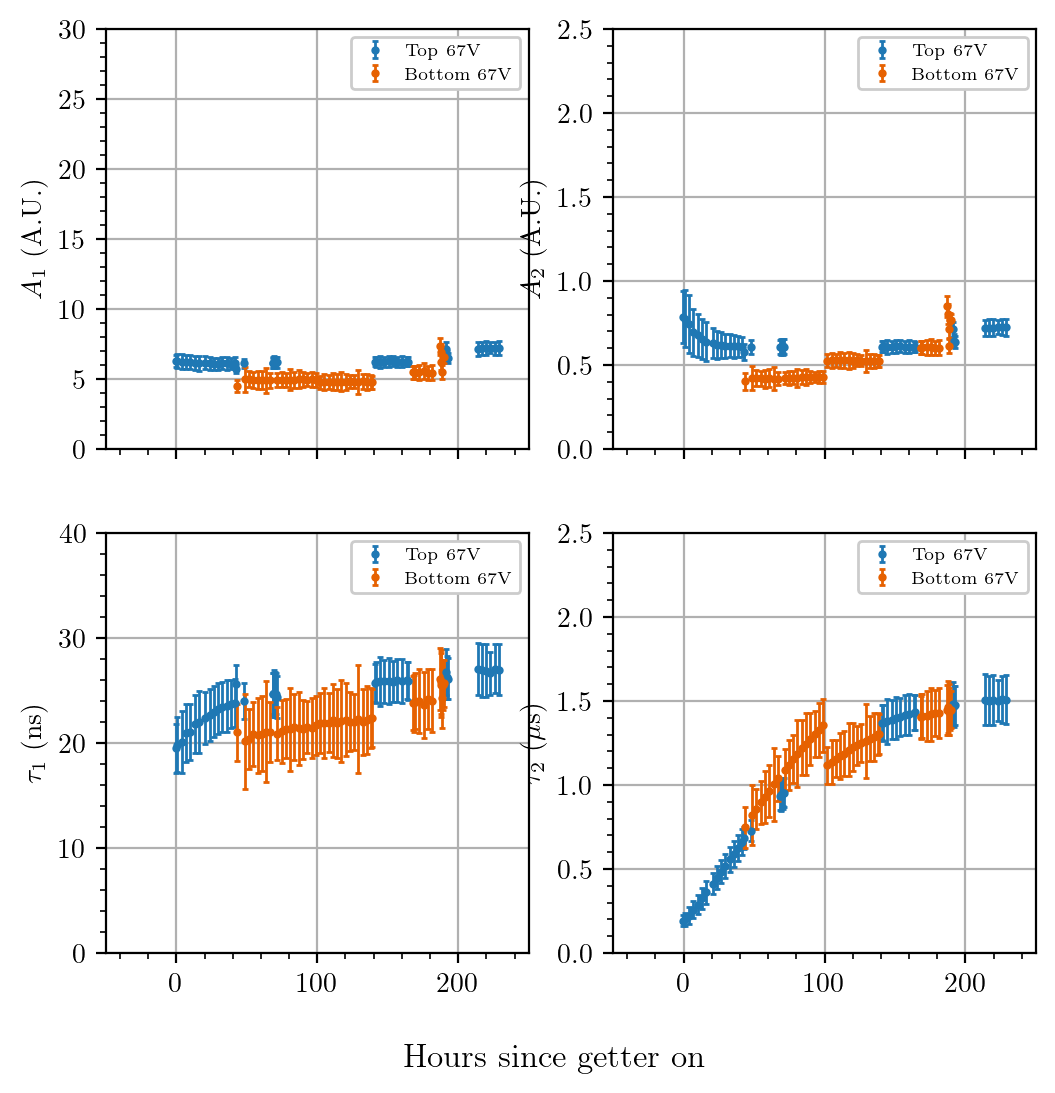

In [28]:
# Make plots for all parameters
# Triplet evolution
fig, axs = plt.subplots(2, 2, sharex=True, sharey=False)
fig.set_size_inches(6, 6)

for pos in positions:
    axs[0, 0].errorbar(
        triplet_fit[pos]['days']*24,
        triplet_fit[pos]['a1'],
        yerr=triplet_fit[pos]['a1err'],
        label=f'{pos[0].upper()}{pos[1:]} 67V', linestyle='', linewidth=1, fmt='o', markersize=2, capsize=1)
    axs[0, 0].set_ylabel(r'$A_1$ (A.U.)')
    axs[0, 0].set_ylim(0,30)

    axs[0, 1].errorbar(
        triplet_fit[pos]['days']*24,
        triplet_fit[pos]['a2'],
        yerr=triplet_fit[pos]['a2err'],
        label=f'{pos[0].upper()}{pos[1:]} 67V', linestyle='', linewidth=1, fmt='o', markersize=2, capsize=1)
    axs[0, 1].set_ylabel(r'$A_2$ (A.U.)')
    axs[0, 1].set_ylim(0,2.5)

    axs[1, 0].errorbar(
        triplet_fit[pos]['days']*24,
        triplet_fit[pos]['tau1']*1e3,
        yerr=triplet_fit[pos]['tau1err']*1e3,
        label=f'{pos[0].upper()}{pos[1:]} 67V', linestyle='', linewidth=1, fmt='o', markersize=2, capsize=1)
    axs[1, 0].set_ylabel(r'$\tau_1$ (ns)')
    axs[1, 0].set_ylim(0,40)

    axs[1, 1].errorbar(
        triplet_fit[pos]['days']*24,
        triplet_fit[pos]['tau2'],
        yerr=triplet_fit[pos]['tau2err'],
        label=f'{pos[0].upper()}{pos[1:]} 67V', linestyle='', linewidth=1, fmt='o', markersize=2, capsize=1)
    axs[1, 1].set_ylabel(r'$\tau_2$ ($\mu$s)')
    axs[1, 1].set_ylim(0,2.5)

for i in range(2):
    for j in range(2):
        axs[i, j].legend(loc='upper right',fontsize=6)
        axs[i, j].minorticks_on()
        axs[i, j].grid()
        axs[i, j].set_xlim(-50,250)
fig.supxlabel('Hours since getter on')